## Packages

In [1]:
using Revise # allows changing imported files without having to restart kernel and must be run first in notebook

In [2]:
include("..\\src\\Modified_Sindy.jl"); 
using .ModifiedSINDy

In [3]:
using DifferentialEquations
using Plots
using Random
using LinearAlgebra
using Distributions
using SavitzkyGolay

## Generating Data

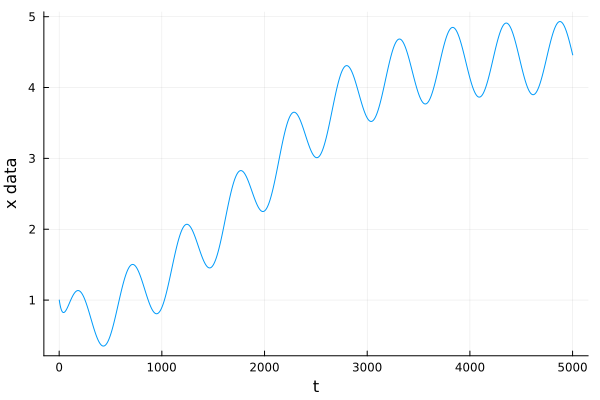

In [4]:
function duffing(du,u,p,t)
    du[1] = u[2]
    du[2] = p[1]*u[1] - p[2]*u[1]^3 - p[3]*u[2] + p[4]*cos(p[5]*u[3])
    du[3] = 1
    return du
end

p0 = [0.2, 0.01, 2.1, 1.4, 1.2]
u0 = [1.0; -1.0; 0]
tspan = (0.0,50.0)

dt = 1e-2
T = tspan[1]:dt:tspan[end]

prob = ODEProblem(duffing, u0, tspan, p0)
sol = solve(prob, RK4(), adaptive = false, dt = dt)
 
u=transpose(Array(sol))
plot(u[:, 1], legend = false, xlabel = "t", ylabel = "x data")

In [5]:
# Define time step
dt=0.01

# Calculate the derivative
du=zeros(size(u))

# Calculate ground truth for derivative
for i=1:size(u,1)
    du[i,:]=duffing(zeros(1,3), u[i,:], p0, 0)
end
#du=du[3:end-2,:];

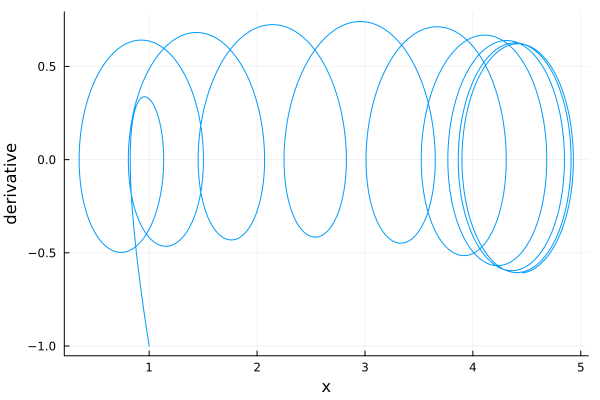

In [6]:
plot(u[:, 1], du[:, 1], legend = false, xlabel = "x", ylabel = "derivative")

In [7]:
function add_noise(NoiseLevel, u)
    # Define the random seed
    Random.seed!(0)

    # Calculate noise magnitude
    NoiseMag=NoiseLevel*std(u,dims=1)/100

    # Generate noise
    Noise=NoiseMag.*randn(size(u))

    # Now, add the noise to the clean data to generate the noisy measurment data
    un=u+Noise;

    # Discard the first and last two points
    un=un[3:end-2,:];
    Noise=Noise[3:end-2,:];
    return un, Noise
end

add_noise (generic function with 1 method)

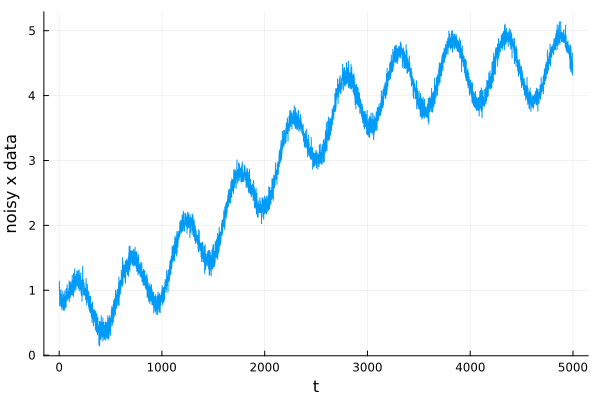

In [8]:
un, noise = add_noise(6, u);
plot(un[:, 1], legend = false, xlabel = "t", ylabel = "noisy x data")

## Noise Reduction

In [9]:
function SG_smoothing_1D(un, dt, window, order)
    # Performs Savitzky Golay smoothing on one dimension
    ues = savitzky_golay(un, window, order).y
    dues = savitzky_golay(un, window, order, deriv=1, rate=1/dt).y
    return ues, dues
end

function SG_smoothing(un, dt, window, order)
    # Runs the Savitzky Golay smoothing on entire data 
    ues, init_dues = SG_smoothing_1D(un[:, 1], dt, window, order)
    for i in 2:size(un)[2]
        ues_next, dues_next = SG_smoothing_1D(un[:, i], dt, window, order)
        ues = hcat(ues, ues_next)
        init_dues = hcat(init_dues, dues_next)
    end
    dues = savitzky_golay(init_dues[:, 1], window, order).y
    for i in 2:size(un)[2]
        dues_next = savitzky_golay(init_dues[:, i], window, order).y
        dues = hcat(dues, dues_next)
    end
    return ues, init_dues, dues
end



function SG_smoothing(un, dt, order; window_step_size=10, ret_window_size = false)
    """
    Performs Savitzky Golay smoothing on noisy data and returns smoothed data as well as derivative estimates.
    Requires an input for the order of polynomial fitting, but window size is automatically determined.

    # Arguments
    * `un`: AbstractArray type holding the noisy data to be smoothed
    * `dt`: Float type holding the timestep spacing between points
    * `order`: Int type that holds the order of polynomial fitting to be used (start at 2 and work up)
    * `window_step_size`: Int type that determines how big the steps should be when determining the optimal window size
    * `ret_window_size`: boolean to return the window size that was used

    # Notes
    * If you want to use a fixed window size, call `SG_smoothing(un, dt, window, order)`
    * Code was adapted from Moving Horizon paper
    """
    un_norm0 = (un[:, 1] .- minimum(un[:, 1])) / (maximum(un[:, 1]) - minimum(un[:, 1]))
    smoothed_vec_0 = [un_norm0]
    std_prev = std(diff(un_norm0))
    window_size_used = order * 2 + 1
    std1 = []
    while true
        push!(std1, std_prev)
        window_size_used += window_step_size
        un_norm0 = savitzky_golay(un_norm0, window_size_used, order).y
        std_new = std(diff(un_norm0))
        if abs((std_new - std_prev) / std_prev) < 0.1
            window_size_used -= window_step_size
            break
        else
            std_prev = std_new
            push!(smoothed_vec_0, un_norm0)
        end
    end

    if window_size_used >= 1
        ret_window_size && return SG_smoothing(un, dt, window_size_used, order)..., window_size_used
        return SG_smoothing(un, dt, window_size_used, order)
    end
end

SG_smoothing (generic function with 2 methods)

In [10]:
# TODO

## SINDy

In [17]:
function Lib(u, x)
    Θ = [u[:,1] u[:,1].^3 u[:,2] u[:,3] cos.(x[1].*u[:,3]) (u[:,3] .* 0 .+ 1)]
    return Θ
end

basis = [term(x -> x[:, 1], 0, 1), 
         term(x -> x[:, 1].^3, 0, 0.5),
         term(x -> x[:, 2], 0.5, 10000),
         term(x -> cos.(1.2.*x[:,3]), 0.1, 300),
         term(x -> x[:,3] .* 0 .+ 1, 0.9, 1.1)];

basis = [term(x -> x[:, 1], 01e-3, 5e-1), 
        term(x -> x[:, 1].^3, 01e-3, 1e-1),
        term(x -> x[:, 2], 0.5, 1e9),
        term(x -> cos.(1.2.*x[:,3]), 0.5, 1e9),
        term(x -> x[:,3] .* 0 .+ 1, 0, 1e9)];

In [12]:
un, noise = add_noise(5, u)
ues, dues, dues_2 = SG_smoothing(un, dt, 3)


Lib_2(u) = Lib(u, [1.2])
λms=exp.(-10:0.1:-0.1)
iter=10
problem = SINDy_Problem(ues, dues_2, Lib_2, λms, iter)
problem.ρ = 1e5
m, l = solve_SINDy(problem)
m

6×3 Matrix{Float64}:
 0.0        0.0      0.0
 0.0        0.0      0.0
 0.998161  -1.60563  0.0
 0.0        0.0      0.0
 0.0        1.15842  0.0
 0.0        0.0      1.00801

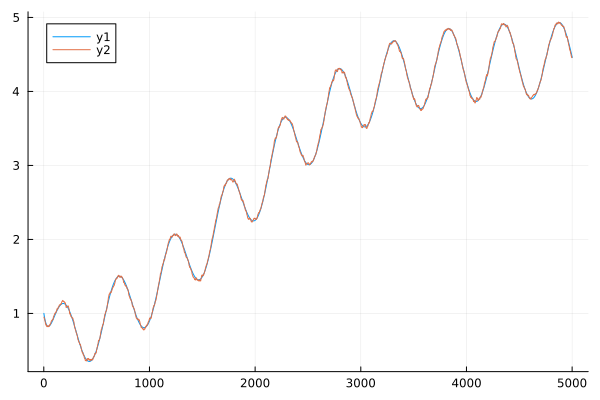

In [13]:
plot(u[:, 1])
plot!(ues[:,1])

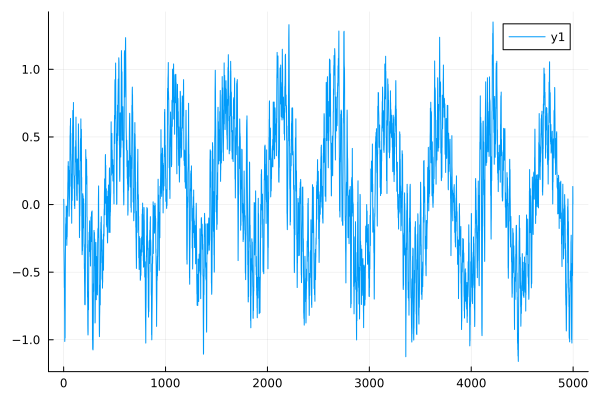

In [14]:
dues_2, _ = SG_smoothing(dues, dt, 3) 
plot(dues[:, 1])
#plot!(dues_2[:, 1])

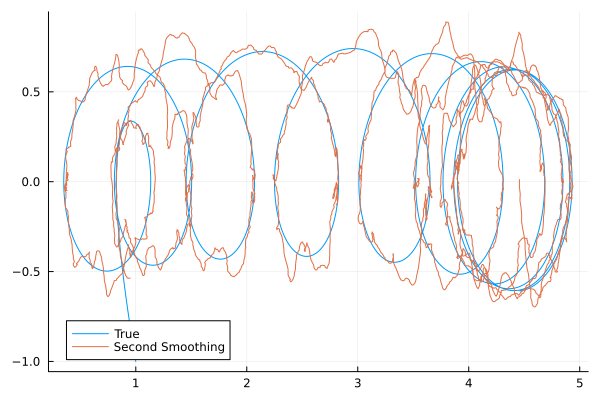

In [15]:
plot(u[:, 1], du[:, 1], label = "True")
#plot!(ues[:, 1], dues[:, 1], label = "Smoothed")
plot!(ues[:, 1], dues_2[:, 1], label = "Second Smoothing")

In [26]:
basis = [term(  x -> x[:, 1],               01e-2,      2e0), 
         term(  x -> x[:, 1].^3,            01e-4,      5e-1),
         term(  x -> x[:, 2],               5e-1,       1e3),
         term(  x -> cos.(1.2.*x[:,3]),     1e0,        1e3),
         term(  x -> x[:,3] .* 0 .+ 1,      0.95,       1.05)]


alg = BPSTLSQ(basis)
prob = SINDy_Problem(ues, dues_2, dt, 10, alg)
m, l = solve_SINDy(prob)
#print(x)
display(m)

5×3 Matrix{Float64}:
 0.0        0.18882     0.0
 0.0       -0.00962614  0.000204901
 0.996005  -1.77939     0.0
 0.0        1.21785     0.0
 0.0        0.0         0.997102

## More